In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
np.random.seed(42)

from jeanneHelper import JeanneHelper

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
helper = JeanneHelper()

In [3]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
#beer_adv_ratings = pd.read_csv("./data/BeerAdvocate/beerAdvocateRatings.csv")
ratings_brotli = pd.read_parquet("./data/BeerAdvocate/ratings_brotli.parquet")

Filter the data and keep only data about USA

In [5]:
df_test = ratings_brotli[ratings_brotli['User_Location'].fillna('').str.startswith('United States,')]

# 1. Intro - Seasonality score

Difference of rating between median summer rating (6-8, june, july, august) and median winter rating (12-2; december, january, february) per style of beer

In [32]:
def calculate_seasonality_score(df, min_reviews = 100):
    temp_df = df.copy()
    summer_months = [6,7,8]
    winter_months = [12,1,2]

    # Create temporary dataset containing only summer and winter months
    temp_df['Season'] = temp_df['Month'].apply(lambda x: 'Summer' if x in summer_months else ('Winter' if x in winter_months else None))
    season_df = temp_df.dropna(subset=['Season'])

    # Remove the style with less than min_reviews for each years 
    yearly_review_counts = season_df.groupby(['Year', 'Style']).size().reset_index(name='Total_Review_Count')
    filtered_styles = yearly_review_counts[yearly_review_counts['Total_Review_Count'] >= min_reviews]

    season_df = season_df.merge(filtered_styles[['Year', 'Style']], on=['Year', 'Style'], how='inner')

    seasonal_stats = season_df.groupby(['Year', 'Style', 'Season']).agg(
        avg_rating=('Rating', 'mean'),
    ).unstack(fill_value=0)

    seasonal_stats['Seasonality_Score'] = seasonal_stats['avg_rating']['Summer'] - seasonal_stats['avg_rating']['Winter']

    return seasonal_stats[['Seasonality_Score']].reset_index()

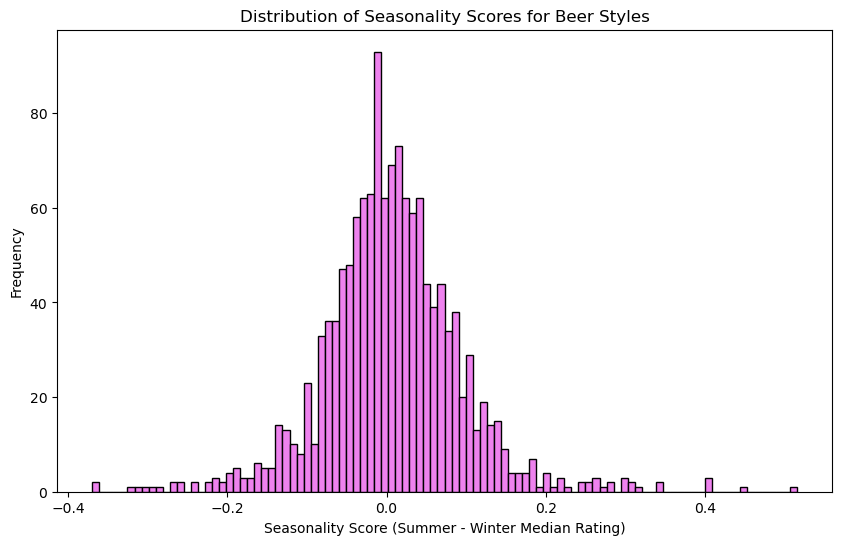

In [33]:
# Calculate seasonality scores
seasonality_scores = calculate_seasonality_score(df_test, min_reviews=100)

# Plot the histogram of seasonality scores
plt.figure(figsize=(10, 6))
#plt.yscale('log')
plt.hist(seasonality_scores['Seasonality_Score'], bins=100, color='violet', edgecolor='black')
plt.xlabel('Seasonality Score (Summer - Winter Median Rating)')
plt.ylabel('Frequency')
plt.title('Distribution of Seasonality Scores for Beer Styles')
plt.show()

### 1.1 Test if data is normally distributed

In [34]:
stat, p_value = shapiro(seasonality_scores['Seasonality_Score'])
print(f"Shapiro-Wilk Test: p-value = {p_value}")

if p_value > 0.05:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

NameError: name 'shapiro' is not defined

In [ ]:
mean_score = seasonality_scores['Seasonality_Score'].mean()
median_score = seasonality_scores['Seasonality_Score'].median()
skewness_score = skew(seasonality_scores['Seasonality_Score'].dropna())

print("Mean Seasonality Score:", mean_score)
print("Median Seasonality Score:", median_score)
print("Skewness of Seasonality Score:", skewness_score)

Mean Seasonality Score: 0.006637713
Median Seasonality Score: 0.006190776824951172
Skewness of Seasonality Score: 0.21837197883286702


### 1.2 Test if mean is significantly different from 0

In [ ]:
# Assume `seasonality_scores` is the array or Series with your seasonality score data
t_stat, p_value = ttest_1samp(seasonality_scores['Seasonality_Score'], 0)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05  # common significance level
if p_value < alpha:
    print("Reject the null hypothesis: The mean seasonality score is significantly different from zero.")
else:
    print("Fail to reject the null hypothesis: The mean seasonality score is not significantly different from zero.")

T-statistic: 2.889312188263239
P-value: 0.0039204364370407415
Reject the null hypothesis: The mean seasonality score is significantly different from zero.


# 2. Beer style seasonality

### 2.1 Seasonality in the Popularity of Beer Styles
We defined the popularity of a beer style based on the number of ratings it received. To examine seasonal trends, we analyzed the top 10 most popular beer styles each month, identifying those that appeared only during specific periods and those that remained consistently in the top ranks.  

As shown in the plot "Top 10 Beer Styles by Number of Reviews per Month (Grouped by Season)" below, certain beer styles appear only during specific periods, such as Pumpkin Ale in the fall, Fruit and Vegetable beers in late spring and summer, Märzen/Oktoberfest beers in September and October, and Winter Warmer in December.  

Other beer styles appear to maintain consistent popularity throughout the year. American IPA is the most rated beer type each month, with American Double/Imperial IPA consistently in second place. Saison/Farmhouse Ale tends to occupy a middle position, while American Amber/Red Ale often ranks near the bottom of the set.  

/Users/jeanneoeuvray/Documents/EPFL/MA1/ADA/ada-2024-project-leonardodatavinci/jeanneHelper.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Period'] = df['Month']


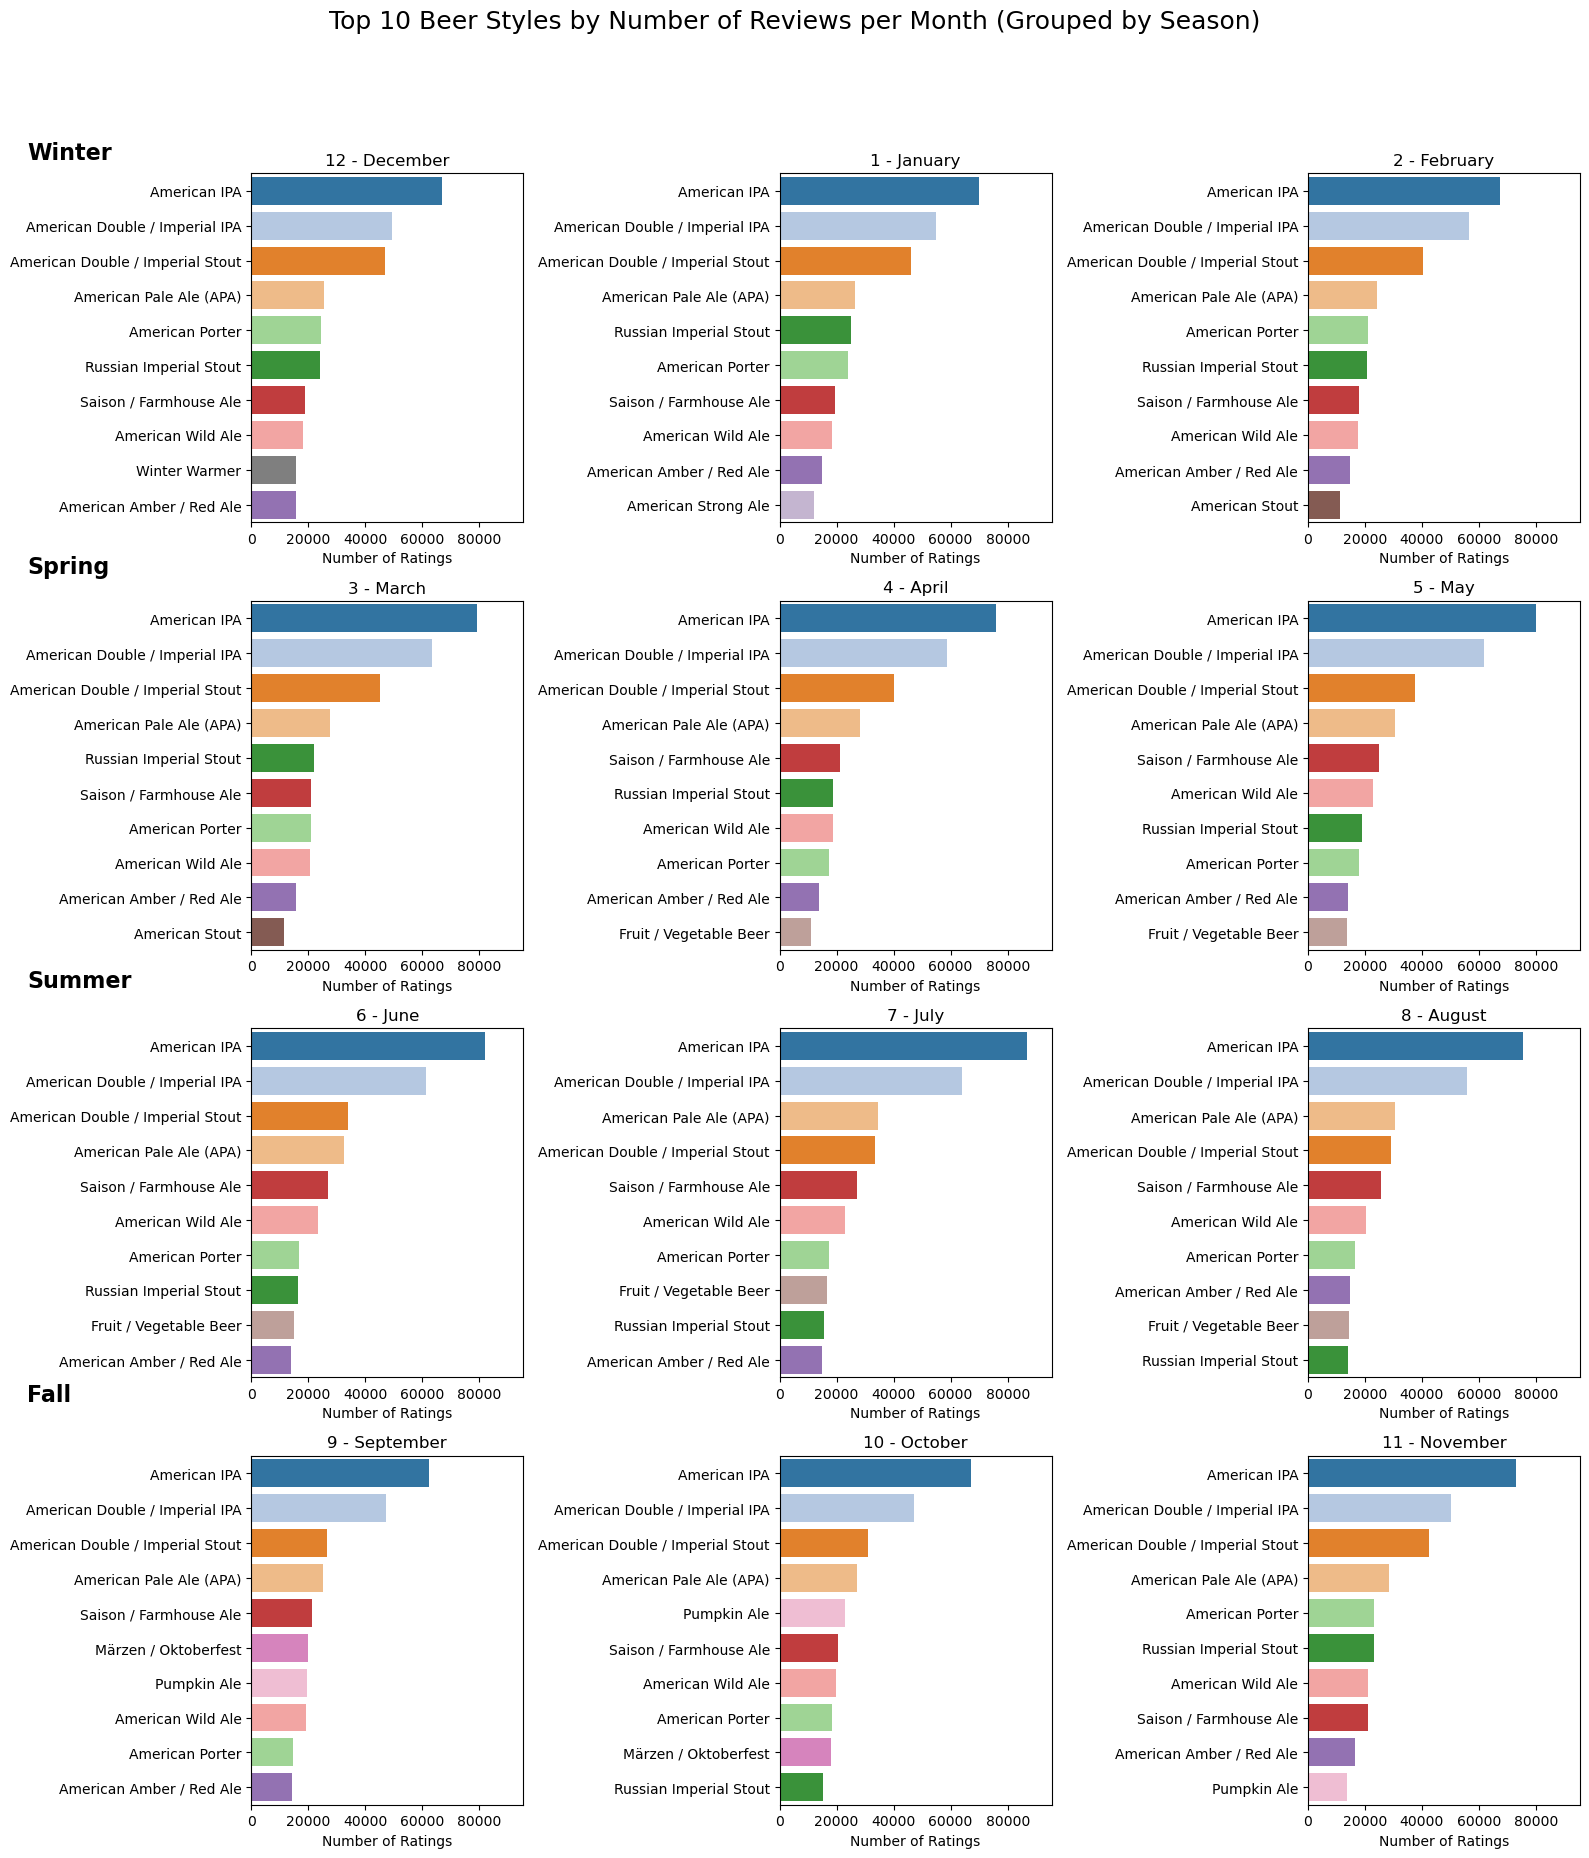

In [19]:
# Get top 10 styles per month
top_styles_per_month = helper.top_k_beer_styles(df = df_test, k = 10, group_by = 'Month')

# Define the seasons and their corresponding months
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

# Create a color palette with a consistent color per beer style
unique_styles = top_styles_per_month['Style'].unique()
palette = sns.color_palette("tab20", len(unique_styles))
style_colors = dict(zip(unique_styles, palette))  # Map each style to a unique color

# Calculate a global maximum for the x-axis limit
max_rating_count = top_styles_per_month['rating_count'].max()

# Initialize the plot with a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(16, 18), constrained_layout=True)

# Loop through each season and each month within the season
for i, (season, months) in enumerate(seasons.items()):
    # Add a large subtitle for the season on the left side
    fig.text(0.02, 0.95 - i * 0.23, season, ha='left', fontsize=16, fontweight='bold', va='center')
    
    for j, month in enumerate(months):
        # Filter data for the specific month
        month_data = top_styles_per_month[top_styles_per_month['Period'] == month]
        
        # Plot in the corresponding subplot
        ax = axes[i, j]
        sns.barplot(
            data=month_data,
            y='Style',
            x='rating_count',
            palette=style_colors,  # Use the consistent color palette
            ax=ax,
            hue='Style',
            legend=False 
        )
        
        # Set the title and labels
        ax.set_title(f"{month} - {pd.to_datetime(f'2023-{month:02d}-01').strftime('%B')}", fontsize=12)  # Display month name
        ax.set_xlabel('Number of Ratings')
        ax.set_ylabel('')  # Remove redundant y-axis label for cleaner look
        ax.set_xlim(0, max_rating_count * 1.1)  # Set a fixed x-axis limit for all plots
        
        # Optional: Adjust y-axis ticks for readability
        ax.tick_params(axis='y', labelsize=10)

# Set the overall title and adjust layout
plt.suptitle("Top 10 Beer Styles by Number of Reviews per Month (Grouped by Season)", fontsize=18, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit the title and subtitles
plt.show()


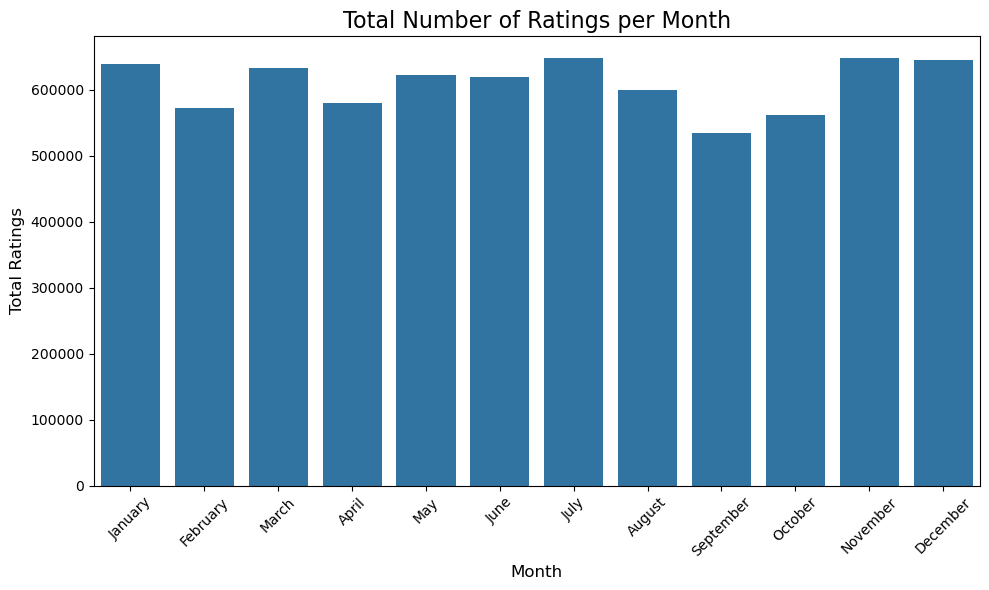

In [17]:
# Aggregate the total number of ratings per month using the 'Month' column
total_ratings_per_month = df_test.groupby('Month').size().reset_index(name='rating_count')

# Sort by month to ensure it is in correct order
total_ratings_per_month = total_ratings_per_month.sort_values(by='Month')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=total_ratings_per_month, x='Month', y='rating_count')

# Customize the plot
plt.title('Total Number of Ratings per Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Ratings', fontsize=12)
plt.xticks(ticks=range(12), labels=[pd.to_datetime(f'2023-{month:02d}-01').strftime('%B') for month in range(1, 13)], rotation=45)
plt.tight_layout()
plt.show()


In [11]:
df_test.head()

,Style,ABV,Dates,Year,Month,Day,Weekday,User_ID,Rating,Review,Appearance,Aroma,Palate,Taste,Overall,Text_NB_Words,User_Location,Period
0,Euro Pale Lager,4.5,1440064800,2015,8,20,3,nmann08.184925,2.88,True,3.25,2.75,3.25,2.75,3.0,59,"United States, Washington",8
1,English Pale Ale,4.5,1235127600,2009,2,20,4,stjamesgate.163714,3.67,True,3.00,3.50,3.50,4.00,3.5,47,"United States, New York",2
5,English Pale Ale,4.8,1417431600,2014,12,1,0,hellpop65.48993,3.25,False,NaN,NaN,NaN,NaN,NaN,0,"United States, Kansas",12
6,English Pale Ale,4.8,1401357600,2014,5,29,3,latarnik.52897,3.50,False,NaN,NaN,NaN,NaN,NaN,0,"United States, New Jersey",5
7,English Pale Ale,4.8,1393412400,2014,2,26,2,rochefortchris.697017,3.50,False,NaN,NaN,NaN,NaN,NaN,0,"United States, North Carolina",2


/Users/jeanneoeuvray/Documents/EPFL/MA1/ADA/ada-2024-project-leonardodatavinci/jeanneHelper.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Period'] = df['Month']


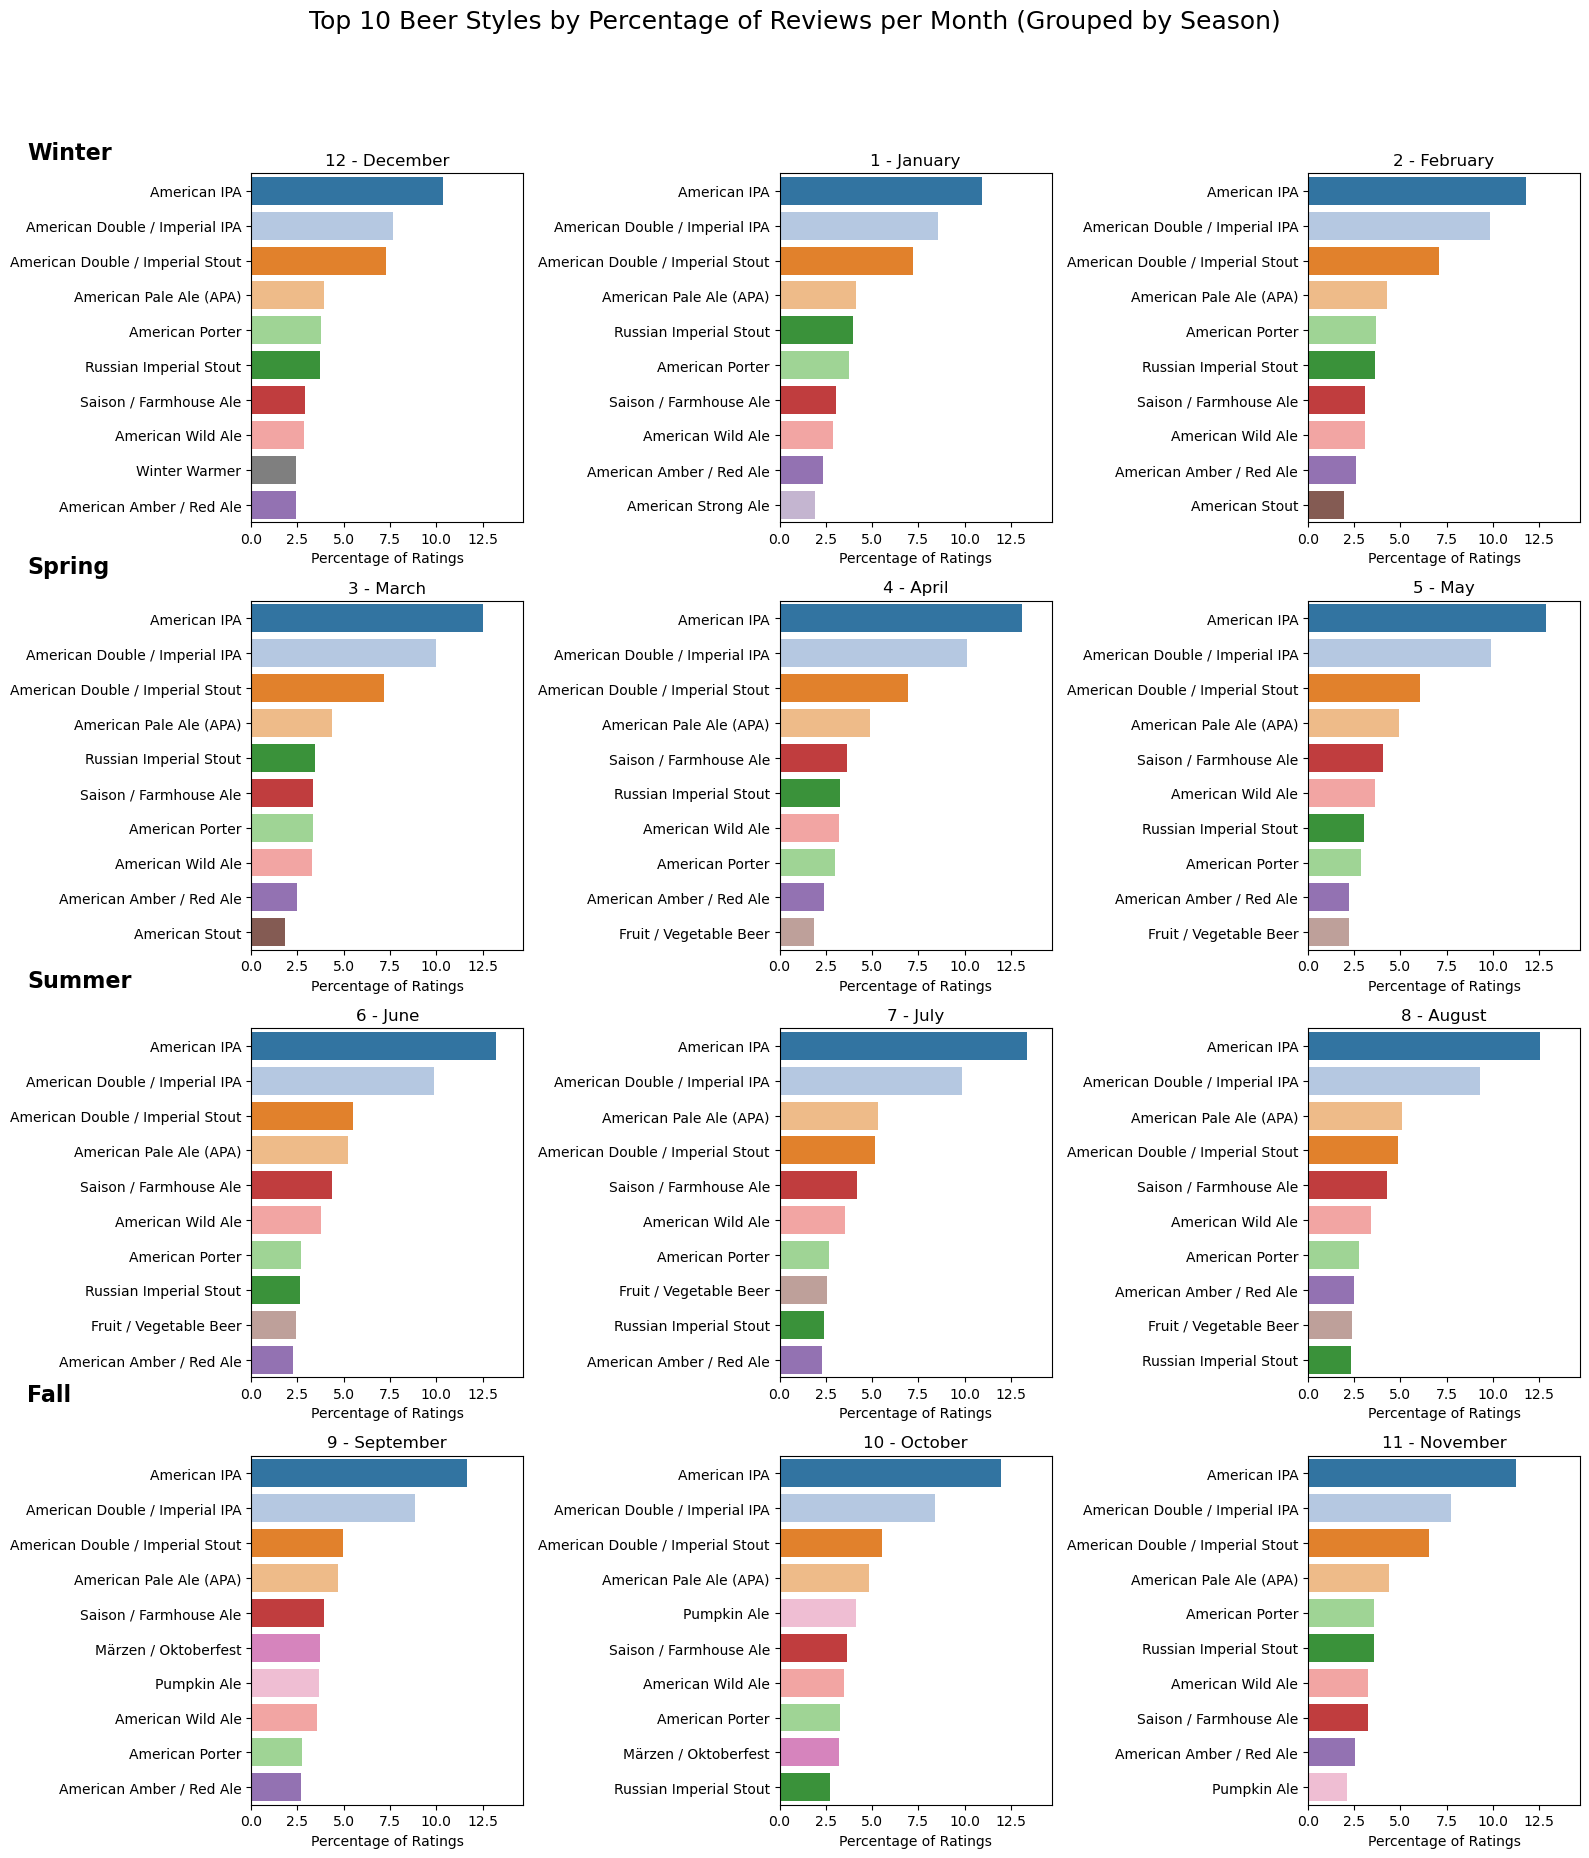

In [ ]:
# Get top 10 styles per month with percentages
top_styles_per_month_percentage = helper.top_k_beer_styles_percentage(df = df_test, k = 10, group_by = 'Month')

# Define the seasons and their corresponding months
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

# Calculate a global maximum for the x-axis limit
max_percentage = top_styles_per_month_percentage['percentage'].max()

# Initialize the plot with a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(16, 18), constrained_layout=True)

# Loop through each season and each month within the season
for i, (season, months) in enumerate(seasons.items()):
    # Add a large subtitle for the season on the left side
    fig.text(0.02, 0.95 - i * 0.23, season, ha='left', fontsize=16, fontweight='bold', va='center')
    
    for j, month in enumerate(months):
        # Filter data for the specific month (using 'Month' instead of 'Period')
        month_data = top_styles_per_month_percentage[top_styles_per_month_percentage['Month'] == month]
        
        # Plot in the corresponding subplot
        ax = axes[i, j]
        sns.barplot(
            data=month_data,
            y='Style',
            x='percentage',  # Use the 'percentage' column instead of 'rating_count'
            palette=style_colors,  # Use the consistent color palette
            ax=ax,
            hue='Style',
            legend=False 
        )
        
        # Set the title and labels
        ax.set_title(f"{month} - {pd.to_datetime(f'2023-{month:02d}-01').strftime('%B')}", fontsize=12)  # Display month name
        ax.set_xlabel('Percentage of Ratings')
        ax.set_ylabel('')  # Remove redundant y-axis label for cleaner look
        ax.set_xlim(0, max_percentage * 1.1)  # Set a fixed x-axis limit for all plots
        
        # Optional: Adjust y-axis ticks for readability
        ax.tick_params(axis='y', labelsize=10)

# Set the overall title and adjust layout
plt.suptitle("Top 10 Beer Styles by Percentage of Reviews per Month (Grouped by Season)", fontsize=18, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit the title and subtitles
plt.show()


### 2.2 Popularity of single types of beers

In [29]:
# Chose the beer styles with interessant features
beer_styles = [
    'Fruit / Vegetable Beer', 'Pumpkin Ale', 'Winter Warmer',  # Seasonal beers
    'American IPA', 'Saison / Farmhouse Ale', 'American Amber / Red Ale'  # Unseasonal beers
]

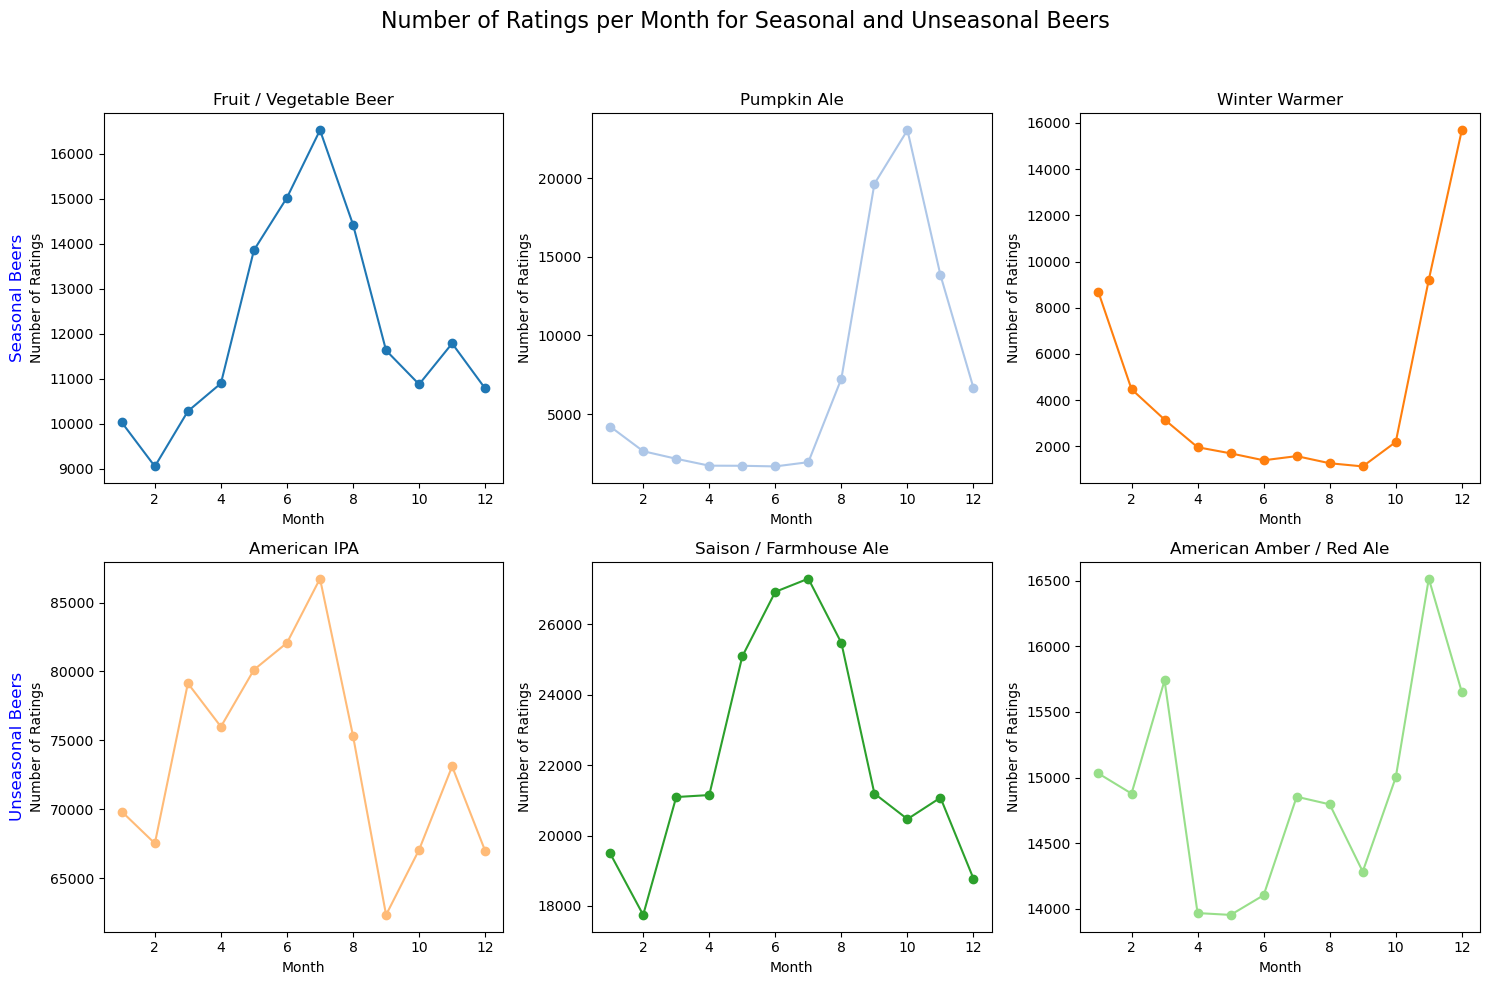

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Number of Ratings per Month for Seasonal and Unseasonal Beers', fontsize=16)

categories = ['Seasonal Beers', 'Unseasonal Beers']

# Loop over each beer style and corresponding subplot for the number of ratings
for idx, (ax, style) in enumerate(zip(axes.flatten(), beer_styles)):
    
    # Filter DataFrame for the current style
    style_df = df_test[df_test['Style'] == style]
    
    # Group by Month and count the number of ratings
    monthly_counts = style_df.groupby('Month').size()
    
    # Plot the monthly counts on the current subplot
    ax.plot(monthly_counts.index, monthly_counts.values, marker='o', linestyle='-', color=style_colors[style])
    ax.set_title(style)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Ratings')
    
    # Add the category label on the left of each row
    if idx % 3 == 0:  # Only add the label on the first column of each row
        row_label = categories[idx // 3]
        ax.annotate(row_label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90, color='blue')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()

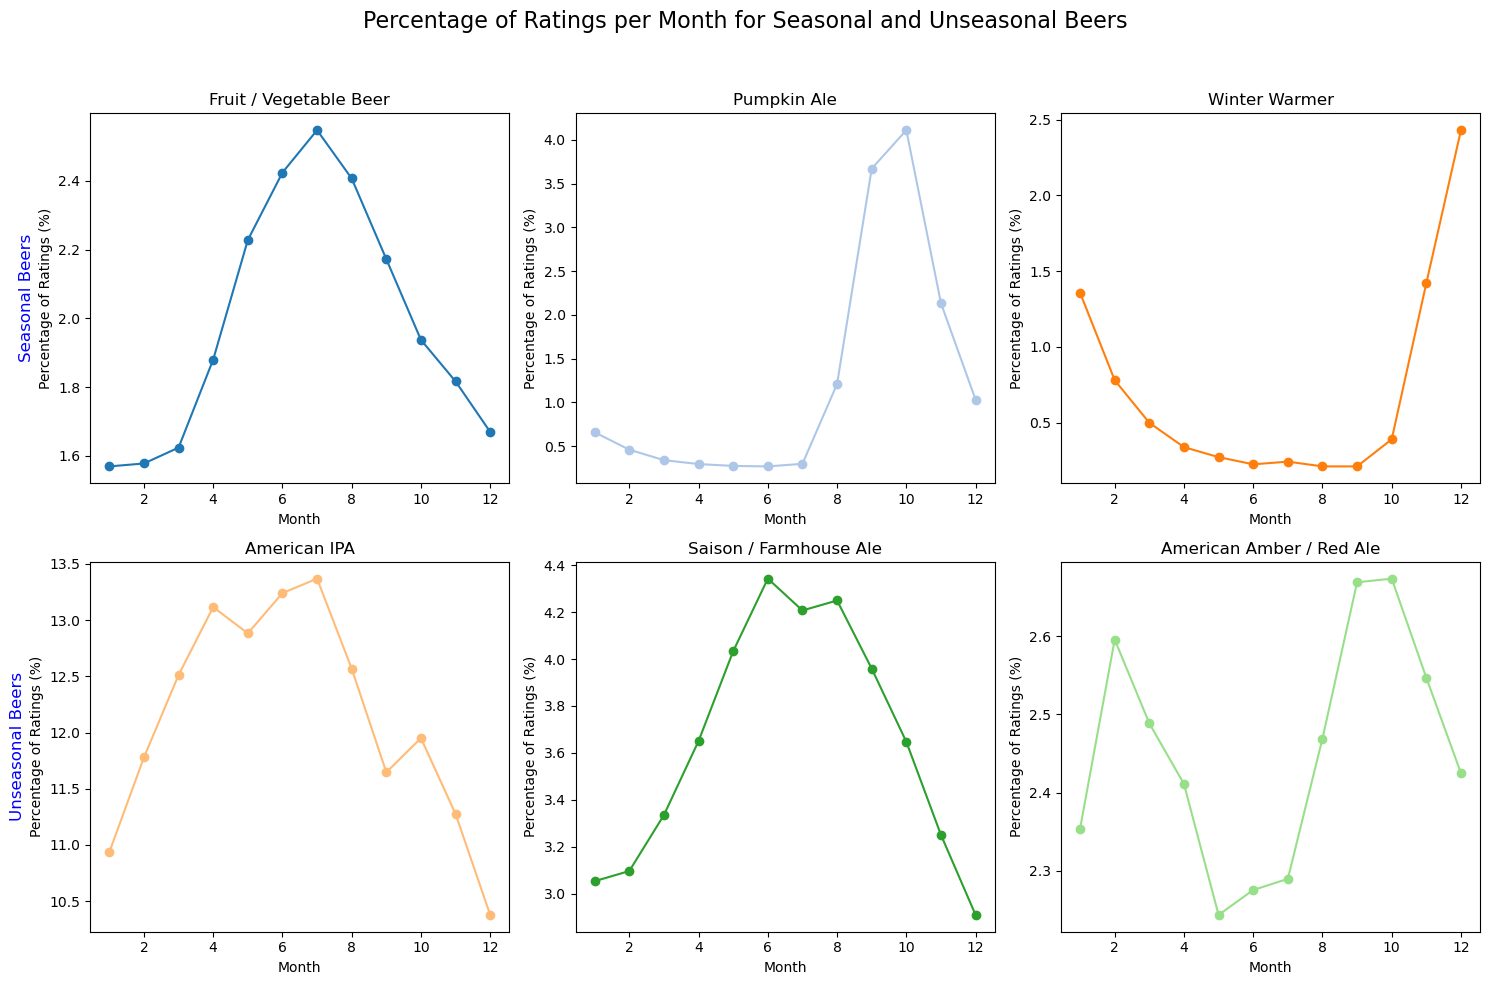

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Percentage of Ratings per Month for Seasonal and Unseasonal Beers', fontsize=16)

# Loop over each beer style and corresponding subplot for percentage of ratings
for idx, (ax, style) in enumerate(zip(axes.flatten(), beer_styles)):
    
    style_df = df_test[df_test['Style'] == style] 
    
    monthly_counts = style_df.groupby('Month').size() # Count number of ratings per month
    
    # Calculate percentage of total ratings per month
    total_monthly_ratings = df_test.groupby('Month').size()
    monthly_percentages = (monthly_counts / total_monthly_ratings) * 100
    
    # Plot the monthly percentages on the current subplot
    ax.plot(monthly_percentages.index, monthly_percentages.values, marker='o', linestyle='-', color=style_colors[style])
    ax.set_title(style)
    ax.set_xlabel('Month')
    ax.set_ylabel('Percentage of Ratings (%)')
    
    # Add the category label on the left of each row
    if idx % 3 == 0:  # Only add the label on the first column of each row
        row_label = categories[idx // 3]
        ax.annotate(row_label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90, color='blue')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()

### 2.3 Rating of those beers depending on the month

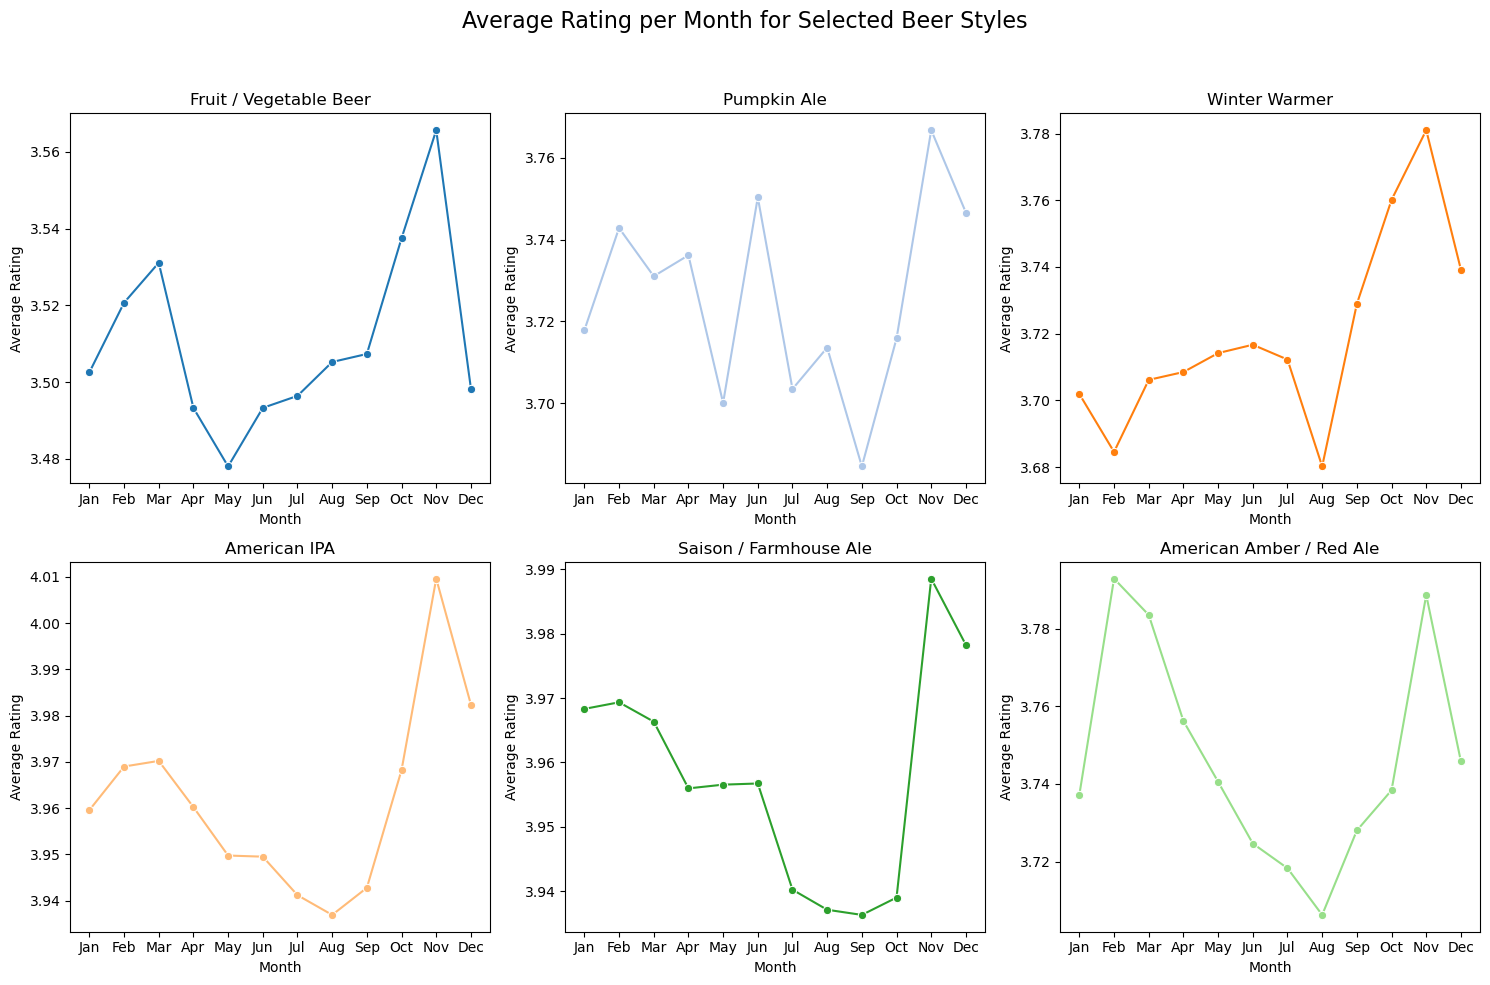

In [28]:
# Define the beer styles to plot
beer_styles = [
    'Fruit / Vegetable Beer', 'Pumpkin Ale', 'Winter Warmer',  # Seasonal beers
    'American IPA', 'Saison / Farmhouse Ale', 'American Amber / Red Ale'  # Unseasonal beers
]

# Filter the dataset for the selected beer styles
df_filtered = df_test[df_test['Style'].isin(beer_styles)]

# Group by Month and Style, then calculate the average rating per group
monthly_ratings = df_filtered.groupby(['Month', 'Style'])['Rating'].mean().reset_index()

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Loop over each beer style and corresponding subplot
for idx, (ax, style) in enumerate(zip(axes.flatten(), beer_styles)):
    
    # Filter data for the current style
    style_df = monthly_ratings[monthly_ratings['Style'] == style]
    
    # Plot the monthly average ratings on the current subplot
    sns.lineplot(data=style_df, x='Month', y='Rating', marker='o', ax=ax, color=style_colors[style])
    
    # Set title and labels for each subplot
    ax.set_title(style, fontsize=12)
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Rating')
    ax.set_xticks(range(1, 13))  # Set x-axis ticks for months
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Adjust the layout and add a main title
fig.suptitle('Average Rating per Month for Selected Beer Styles', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title

# Display the plot
plt.show()


# 3. Degree of seasonality depending on latitude

We initially considered exploring the degree of seasonality depending on latitude to understand how variations in weather conditions, influenced by geographical location, might affect beer ratings. The basic idea was that regions further from the equator experience more pronounced seasonal changes, which could potentially impact local beer preferences and ratings. However, after reviewing the literature, we found that defining a "degree of seasonality" solely based on latitude is overly simplistic and not widely established in existing studies.  

In a relevant study (https://academic.oup.com/icb/article/57/5/934/3896236), it was highlighted that seasonality is influenced by factors beyond latitude, such as the Earth's axial tilt, which causes different regions at the same latitude to experience varying degrees of seasonality. Factors like day length and temperature, which are not directly linked to latitude, also play a crucial role in determining seasonal changes. While weather data could provide insights into these variables, we would still face challenges in combining them into a comprehensive metric for seasonality.  

Given these complexities and the lack of a well-defined measure in the literature, we decided to abandon the idea of creating a latitude-based seasonality metric, as it would have required arbitrary assumptions and lacked a clear, scientifically grounded foundation.  